In [1]:
# Block 1: Upload ZIP and extract CSV
from google.colab import files
import zipfile
import os
import pandas as pd

# Step 1: Upload your ZIP file
print("Please upload your dataset ZIP file:")
uploaded = files.upload()  # This will prompt you to upload the ZIP

# Step 2: Extract ZIP file
zip_path = list(uploaded.keys())[0]  # Get uploaded file name
extract_folder = "spam_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Files extracted to folder: {extract_folder}")

# Step 3: Find the CSV inside extracted folder
csv_files = [f for f in os.listdir(extract_folder) if f.endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in the ZIP.")
csv_path = os.path.join(extract_folder, csv_files[0])
print(f"CSV file found: {csv_path}")

# Step 4: Load CSV into DataFrame
df = pd.read_csv(csv_path, encoding='latin-1')  # Adjust encoding if needed
df = df[['v1', 'v2']]  # Keep only label and message columns
df.columns = ['label', 'message']

print("Dataset loaded successfully! Here's a preview:")
df.head()


Please upload your dataset ZIP file:


Saving archive (1).zip to archive (1).zip
Files extracted to folder: spam_data
CSV file found: spam_data/spam.csv
Dataset loaded successfully! Here's a preview:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


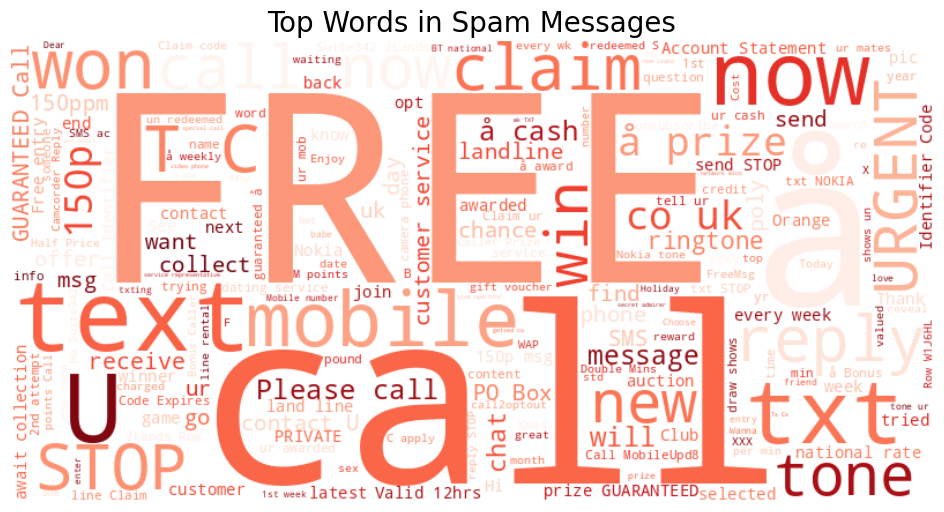

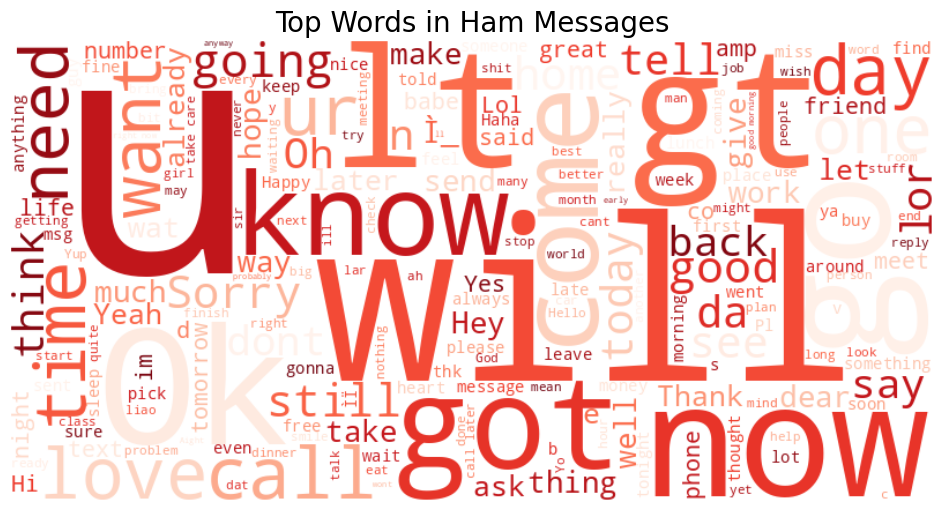

In [2]:
# Block 2: Data Exploration & Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

# ---------------------------
# 1. Basic dataset info
print("Dataset info:")
print(df.info())
print("\nLabel distribution:")
print(df['label'].value_counts())

# ---------------------------
# 2. Spam vs Ham distribution (Interactive)
fig1 = px.pie(df, names='label', title='Spam vs Ham Message Distribution', color='label',
              color_discrete_map={'ham':'green', 'spam':'red'})
fig1.show()

# ---------------------------
# 3. Message length feature
df['msg_len'] = df['message'].apply(len)

# Interactive histogram of message lengths
fig2 = px.histogram(df, x='msg_len', color='label', barmode='overlay',
                    color_discrete_map={'ham':'green','spam':'red'},
                    title='Message Length Distribution by Label')
fig2.show()

# ---------------------------
# 4. WordClouds for Spam & Ham messages
def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Spam messages WordCloud
spam_text = " ".join(df[df['label']=='spam']['message'])
generate_wordcloud(spam_text, "Top Words in Spam Messages")

# Ham messages WordCloud
ham_text = " ".join(df[df['label']=='ham']['message'])
generate_wordcloud(ham_text, "Top Words in Ham Messages")


In [3]:
# Block 3: Text Preprocessing & Feature Engineering
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# ---------------------------
# 1. Text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\W', ' ', text)  # remove special characters
    text = re.sub(r'\d', '', text)   # remove numbers
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply cleaning
df['clean_message'] = df['message'].apply(clean_text)

# ---------------------------
# 2. Additional features
df['msg_len'] = df['message'].apply(len)  # message length
df['num_special_chars'] = df['message'].apply(lambda x: len(re.findall(r'\W', x)))
df['num_numbers'] = df['message'].apply(lambda x: len(re.findall(r'\d', x)))

# ---------------------------
# 3. Encode label for ML
df['label_num'] = df['label'].map({'ham':0, 'spam':1})

# Preview the cleaned dataset
print("Preview of cleaned dataset with features:")
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Preview of cleaned dataset with features:


,label,message,msg_len,clean_message,num_special_chars,num_numbers,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...,28,0,0
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,11,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...,33,25,1
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say,16,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though,14,0,0


In [4]:
# Block 4: TF-IDF Feature Extraction & Data Preparation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import numpy as np

# ---------------------------
# 1. Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigram + bigram

# Fit and transform cleaned messages
X_text = tfidf.fit_transform(df['clean_message'])

# ---------------------------
# 2. Combine additional features
# Convert additional features to array
additional_features = df[['msg_len','num_special_chars','num_numbers']].values

# Combine TF-IDF sparse matrix with additional features
from scipy.sparse import csr_matrix
X = hstack([X_text, csr_matrix(additional_features)])

# Target variable
y = df['label_num'].values

# ---------------------------
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 4457, Testing samples: 1115


In [16]:
# -------------------------------

# -------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Assuming df is already loaded from Block 1–3
# Columns: 'message', 'label_num', 'msg_len', 'num_special_chars', 'num_numbers'

# -------------------------------
# 1. Train/Test Split
X = df['message']
y = df['label_num']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 2. TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = tfidf.fit_transform(X_train_text)
X_test_vec = tfidf.transform(X_test_text)

# -------------------------------
# 3. Model Training (In-Memory)
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# -------------------------------
# 4. Evaluate Accuracy
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model trained successfully. Test Accuracy: {accuracy*100:.2f}%")

# -------------------------------
# 5. Now, model and tfidf are in memory
# Ready for Block 6 dashboard


✅ Model trained successfully. Test Accuracy: 97.22%


✅ Naive Bayes trained in 0.01s - Accuracy: 0.968, F1: 0.876, ROC-AUC: 0.943
✅ Logistic Regression trained in 0.23s - Accuracy: 0.979, F1: 0.918, ROC-AUC: 0.995
✅ Random Forest trained in 7.68s - Accuracy: 0.986, F1: 0.943, ROC-AUC: 0.990

🏆 Best Model: Logistic Regression


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.



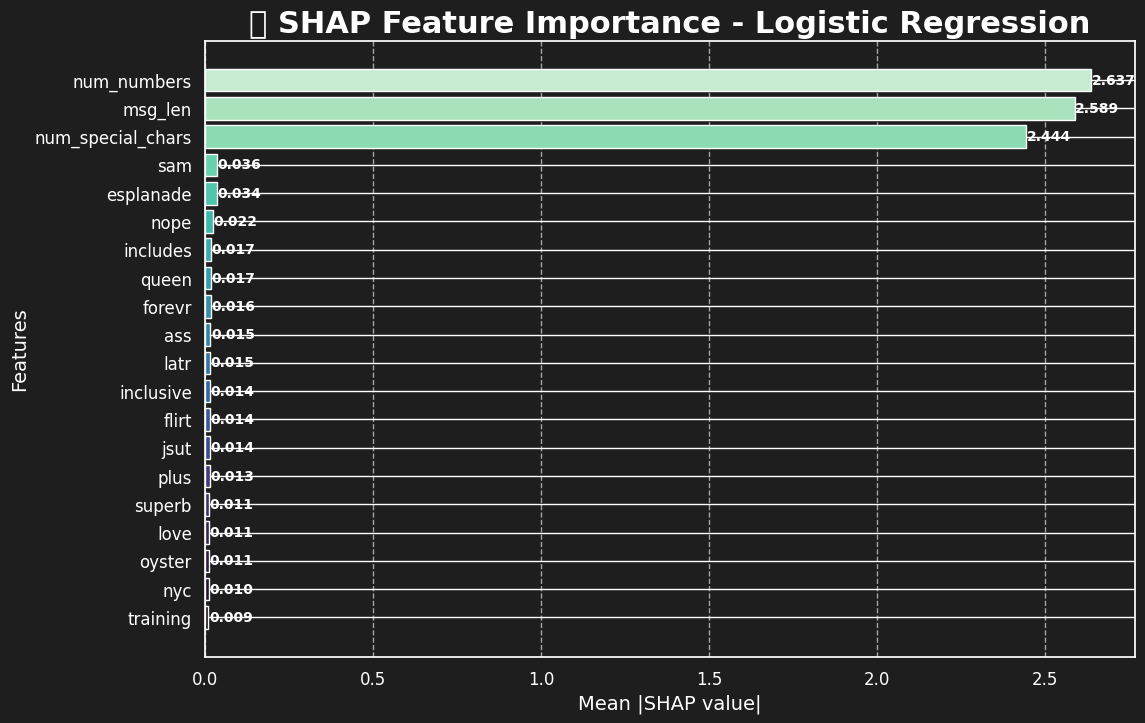

In [29]:
# ================================================
import numpy as np
import pandas as pd
import shap
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time

# ---------------------------
# 1. Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results = []
fitted_models = {}

# ---------------------------
# 2. Train & Evaluate Models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    fitted_models[name] = model

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, f1, roc])
    print(f"✅ {name} trained in {time.time()-start_time:.2f}s - Accuracy: {acc:.3f}, F1: {f1:.3f}, ROC-AUC: {roc:.3f}")

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1", "ROC-AUC"])
best_model_name = results_df.sort_values("ROC-AUC", ascending=False).iloc[0]["Model"]
best_model = fitted_models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")

# ---------------------------

fig_perf.update_layout(
    title="🚀 Model Performance Comparison",
    barmode="group",
    template="plotly_dark",
    width=850,
    height=600,
    xaxis_title="Models",
    yaxis_title="Score",
    yaxis=dict(range=[0,1.05]),
    title_font_size=26,
    legend_title="Metrics"
)
fig_perf.show()

# ---------------------------
# 4. Confusion Matrix - Modern Gradient & Interactive Hover
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ["Ham", "Spam"]
hover_text = [[f"Actual: {labels[i]}<br>Predicted: {labels[j]}<br>Count: {cm[i,j]}<br>Percentage: {cm_percent[i,j]*100:.2f}%"
               for j in range(len(labels))] for i in range(len(labels))]
fig_cm = go.Figure(data=go.Heatmap(
    z=cm_percent,
    x=labels,
    y=labels,
    text=hover_text,
    hoverinfo="text",
    colorscale='Viridis',  # modern, visually distinct
    showscale=True
))
fig_cm.update_layout(
    title=f"🧮 Confusion Matrix - {best_model_name}",
    template="plotly_dark",
    width=800,
    height=600,
    xaxis_title="Predicted",
    yaxis_title="Actual"
)
fig_cm.show()

# ---------------------------
# 5. ROC Curve - Shaded, Modern, Interactive
if hasattr(best_model, "predict_proba"):
    y_prob_best = best_model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
    fig_roc = go.Figure()
    fig_roc.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines+markers',
                                 line=dict(color='#FF69B4', width=4),  # HotPink for curve
                                 name='ROC Curve',
                                 hovertemplate='FPR: %{x:.2f}<br>TPR: %{y:.2f}<extra></extra>'))
    fig_roc.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Random',
                                 line=dict(color='white', width=3, dash='dash')))
    fig_roc.add_trace(go.Scatter(x=np.concatenate([fpr, fpr[::-1]]),
                                 y=np.concatenate([tpr, np.zeros_like(tpr)]),
                                 fill='toself', fillcolor='rgba(255,105,180,0.2)',
                                 line=dict(color='rgba(0,0,0,0)'), hoverinfo='skip', showlegend=False))
    fig_roc.update_layout(
        title=f"📈 ROC Curve - {best_model_name}",
        template="plotly_dark",
        width=850,
        height=600,
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate"
    )
    fig_roc.show()

# ---------------------------
# 6. SHAP Feature Importance - Modern Color Palette, Horizontal Bars
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test[:500])
feature_names = tfidf.get_feature_names_out().tolist() + ['msg_len', 'num_special_chars', 'num_numbers']

# Mean absolute SHAP values
shap_mean = np.abs(shap_values.values).mean(0)
shap_df = pd.DataFrame({'feature': feature_names, 'importance': shap_mean}).sort_values(by='importance', ascending=True)
top_features = shap_df.tail(20)
palette = sns.color_palette("mako", n_colors=len(top_features))  # distinct, modern

plt.figure(figsize=(12,8))
bars = plt.barh(top_features['feature'], top_features['importance'], color=palette)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=10, fontweight='bold', color='white')

plt.title(f"🌟 SHAP Feature Importance - {best_model_name}", fontsize=22, fontweight='bold', color='white')
plt.xlabel("Mean |SHAP value|", fontsize=14, color='white')
plt.ylabel("Features", fontsize=14, color='white')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#1E1E1E')
plt.gcf().patch.set_facecolor('#1E1E1E')
plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)
plt.show()


In [26]:
import plotly.graph_objects as go

# Replace this with your actual results_df
# Example:
# results_df = pd.DataFrame({
#     "Model": ["Naive Bayes", "Logistic Regression", "Random Forest"],
#     "Accuracy": [0.92, 0.95, 0.97],
#     "F1": [0.90, 0.94, 0.96],
#     "ROC-AUC": [0.91, 0.95, 0.97]
# })

metrics = ["Accuracy", "F1", "ROC-AUC"]

# Distinct real colors for each bar (manually selected)
bar_colors_matrix = [
    ["#FF5733", "#33FF57", "#3357FF"],  # Accuracy bars
    ["#FFC300", "#DAF7A6", "#FF33FF"],  # F1 bars
    ["#00FFFF", "#FF00FF", "#FFA500"]   # ROC-AUC bars
]

fig = go.Figure()

for i, metric in enumerate(metrics):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        name=metric,
        marker_color=bar_colors_matrix[i],  # Each bar visually distinct
        text=results_df[metric].round(3),
        textposition="auto",
        hovertemplate="<b>%{x}</b><br>"+metric+": %{y:.3f}<extra></extra>"
    ))

fig.update_layout(
    title="Model Performance Comparison ",
    barmode="group",
    template="plotly_dark",
    width=900,
    height=600,
    xaxis_title="Models",
    yaxis_title="Score",
    yaxis=dict(range=[0,1.05]),
    title_font_size=28,
    legend_title="Metrics",
    font=dict(family="Arial, sans-serif", size=14, color="white")
)

fig.show()


In [33]:
# ================================================
# BLOCK 5: Advanced Interactive Visualizations
# ================================================

import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter



# ---------------------------
# 2️⃣ Message Length Distribution
df['msg_len'] = df['message'].apply(len)
fig_len = px.histogram(
    df, x='msg_len', color='label',
    nbins=50, marginal='box',
    color_discrete_map={'ham':'#3498DB', 'spam':'#F39C12'},
    title="✉️ Message Length Distribution (Ham vs Spam)"
)
fig_len.update_layout(template='plotly_dark', width=800, height=600)
fig_len.show()

# ---------------------------
# 3️⃣ Number of Special Characters vs Label
df['num_special_chars'] = df['message'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))
fig_special = px.violin(
    df, y='num_special_chars', x='label', box=True, points='all',
    color='label',
    color_discrete_map={'ham':'#9B59B6', 'spam':'#E67E22'},
    title="❗ Special Characters Count Distribution"
)
fig_special.update_layout(template='plotly_dark', width=800, height=600)
fig_special.show()

# ---------------------------
#

# ---------------------------
#


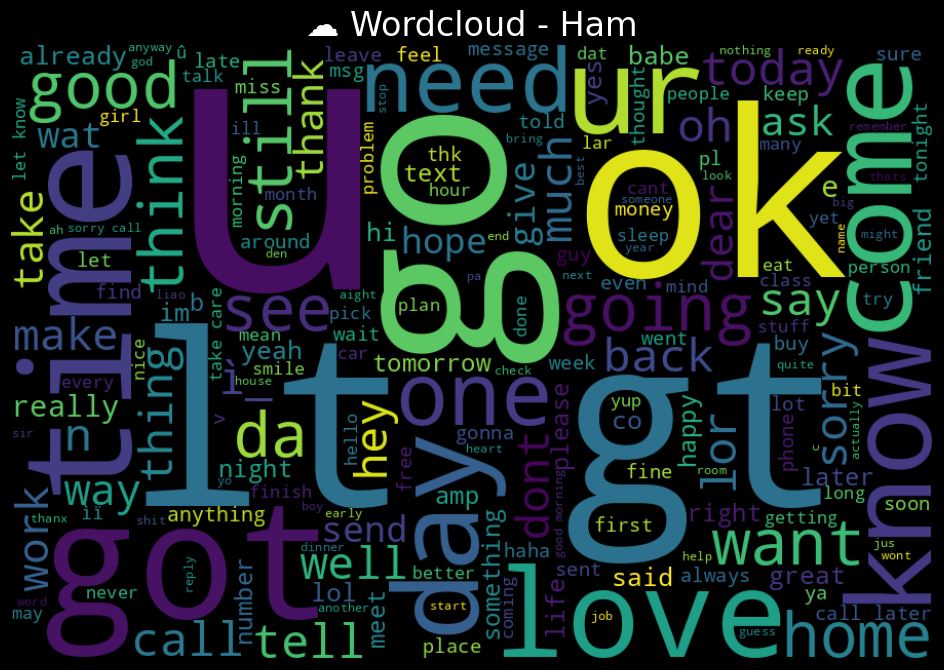

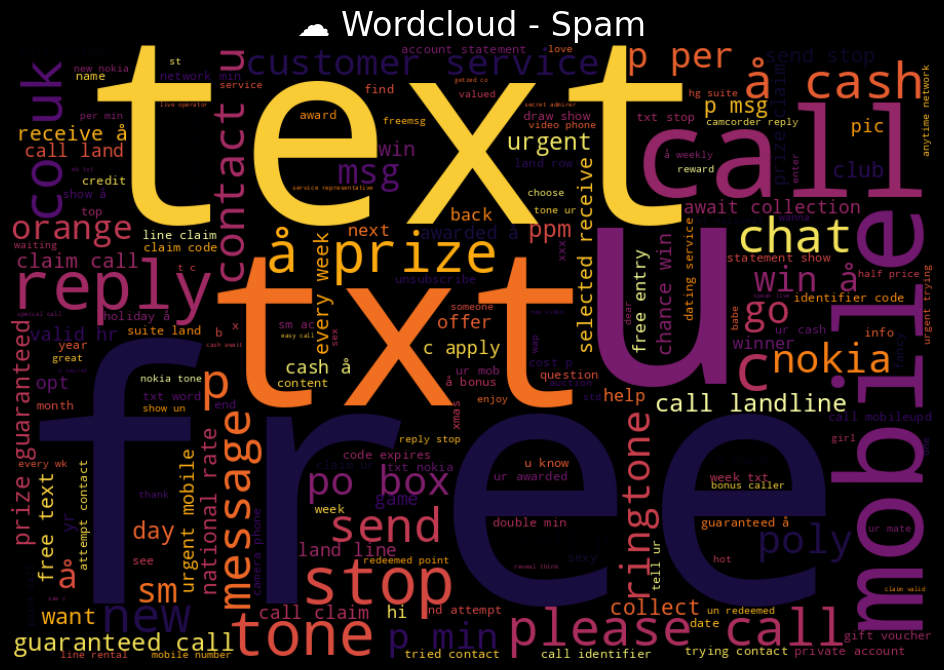

In [31]:
# ================================================
# Advanced, Premium Visualizations - Email Spam Detection
# ================================================

import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ---------------------------
# 1. Spam vs Ham Count - Horizontal Bar, Modern Colors
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
fig_label = px.bar(
    label_counts,
    x='Count',
    y='Label',
    orientation='h',
    text='Count',
    color='Label',
    color_discrete_map={'ham':'#1f77b4', 'spam':'#ff7f0e'},
    title="📧 Spam vs Ham Count",
    template="plotly_dark",
    width=900,
    height=600
)
fig_label.update_traces(textposition='auto', marker_line_width=1.5)
fig_label.show()

# ---------------------------
# 2. Message Length Distribution - Violin Plot, Interactive
fig_len = px.violin(
    df, x='label', y='msg_len', color='label',
    box=True, points="all",
    color_discrete_map={'ham':'#2ca02c', 'spam':'#d62728'},
    title="📏 Message Length Distribution",
    template="plotly_dark",
    width=900,
    height=600
)
fig_len.update_traces(meanline_visible=True)
fig_len.show()

# ---------------------------
# 3. Special Characters & Numbers - Side-by-Side Violin
df_melted = df.melt(id_vars=['label'], value_vars=['num_special_chars','num_numbers'],
                    var_name='Feature', value_name='Count')

fig_special = px.violin(
    df_melted, x='Feature', y='Count', color='label',
    box=True, points="all",
    color_discrete_map={'ham':'#9467bd', 'spam':'#8c564b'},
    title="🔢 Special Characters & Numbers Distribution",
    template="plotly_dark",
    width=900,
    height=600
)
fig_special.update_traces(meanline_visible=True)
fig_special.show()

# ---------------------------
# 4. Top Words in Spam vs Ham - Horizontal Bar
from collections import Counter
import re

def top_words(df_sub, n=15):
    words = ' '.join(df_sub['clean_message']).lower().split()
    words = [re.sub(r'\W+', '', w) for w in words if w.isalpha()]
    return dict(Counter(words).most_common(n))

top_ham = top_words(df[df['label']=='ham'])
top_spam = top_words(df[df['label']=='spam'])

# Ham
fig_top_ham = go.Figure(go.Bar(
    x=list(top_ham.values())[::-1],
    y=list(top_ham.keys())[::-1],
    orientation='h',
    marker_color=px.colors.sequential.Viridis[::-1],
    text=list(top_ham.values())[::-1],
    textposition="auto"
))
fig_top_ham.update_layout(
    title="🟦 Top Words in Ham Messages",
    template="plotly_dark",
    width=900, height=600
)
fig_top_ham.show()

# Spam
fig_top_spam = go.Figure(go.Bar(
    x=list(top_spam.values())[::-1],
    y=list(top_spam.keys())[::-1],
    orientation='h',
    marker_color=px.colors.sequential.Inferno[::-1],
    text=list(top_spam.values())[::-1],
    textposition="auto"
))
fig_top_spam.update_layout(
    title="🟥 Top Words in Spam Messages",
    template="plotly_dark",
    width=900, height=600
)
fig_top_spam.show()

# ---------------------------
# 5. Wordclouds - Ham vs Spam
def plot_wordcloud(df_sub, label_name, colormap):
    text = ' '.join(df_sub['clean_message'])
    wc = WordCloud(width=900, height=600, background_color='black', colormap=colormap).generate(text)
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"☁️ Wordcloud - {label_name}", fontsize=24, color='white')
    plt.show()

plot_wordcloud(df[df['label']=='ham'], 'Ham', 'viridis')
plot_wordcloud(df[df['label']=='spam'], 'Spam', 'inferno')

# ---------------------------
# 6. Correlation Heatmap (Numeric Features) - Interactive
numeric_features = ['msg_len','num_special_chars','num_numbers']
corr = df[numeric_features].corr()

fig_corr = px.imshow(
    corr, text_auto=True, aspect="auto",
    color_continuous_scale='plasma',
    title="🧩 Correlation Heatmap - Numeric Features",
    template="plotly_dark",
    width=900, height=600
)
fig_corr.show()


In [34]:
# ============================
# 3. SHAP / Explainable AI Visuals
# ============================

import shap
import plotly.express as px
import pandas as pd
import numpy as np

# Limit X_test for faster visualization
X_shap = X_test[:500]

# Create SHAP explainer for the best model
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_shap)

# Convert SHAP values to DataFrame for plotting
shap_df = pd.DataFrame(shap_values.values, columns=tfidf.get_feature_names_out().tolist() + ['msg_len','num_special_chars','num_numbers'])

# Compute mean absolute SHAP values for global feature importance
shap_mean = shap_df.abs().mean().sort_values(ascending=False).head(20).reset_index()
shap_mean.columns = ['Feature','Mean_Impact']

# ---------------------------
# Horizontal Bar Plot for Global Importance
fig_shap_bar = px.bar(
    shap_mean[::-1],  # reverse for top-down display
    x='Mean_Impact',
    y='Feature',
    orientation='h',
    color='Mean_Impact',
    color_continuous_scale=px.colors.sequential.Viridis,
    text='Mean_Impact',
    title='🧩 SHAP Global Feature Importance (Top 20)',
    height=600,
    width=800
)
fig_shap_bar.update_layout(
    template='plotly_dark',
    xaxis_title='Mean |SHAP Value|',
    yaxis_title='Feature',
    title_font_size=22,
    coloraxis_colorbar=dict(title="Impact")
)
fig_shap_bar.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig_shap_bar.show()


In [35]:
# ============================
# 5. Advanced Numeric Feature Analysis
# ============================

import plotly.express as px
import plotly.graph_objects as go

# Select numeric features
num_features = ['msg_len', 'num_special_chars', 'num_numbers']

# ---------------------------
# 1. Correlation Heatmap
corr_matrix = df[num_features + ['label_num']].corr()
fig_corr = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale=px.colors.sequential.Plasma,
    title="🔥 Correlation Heatmap of Numeric Features",
    labels=dict(color="Correlation"),
    width=700,
    height=600
)
fig_corr.update_layout(template='plotly_dark')
fig_corr.show()

# ---------------------------
# 2. Distribution Plots (Histogram + Density)
for feature in num_features:
    fig_dist = px.histogram(
        df,
        x=feature,
        color='label',
        marginal="violin",  # adds a mini violin plot
        barmode='overlay',
        histnorm='density',
        title=f"📊 Distribution of {feature} by Label",
        height=500,
        width=750,
        color_discrete_map={'ham':'#1E90FF', 'spam':'#FF4500'}
    )
    fig_dist.update_layout(template='plotly_dark')
    fig_dist.show()

# ---------------------------
# 3. Boxplots for Outlier Detection
for feature in num_features:
    fig_box = px.box(
        df,
        x='label',
        y=feature,
        color='label',
        title=f"📦 Boxplot of {feature} by Label",
        width=750,
        height=500,
        color_discrete_map={'ham':'#1E90FF', 'spam':'#FF4500'}
    )
    fig_box.update_layout(template='plotly_dark')
    fig_box.show()


In [36]:
# ============================
# 6. Confusion Matrix & Model Evaluation
# ============================

import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Predictions from the best model
y_pred_best = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = ['Ham', 'Spam']

# Hover text for each cell
hover_text = [[f"Actual: {labels[i]}<br>Predicted: {labels[j]}<br>Count: {cm[i,j]}<br>Percentage: {cm_percent[i,j]:.2f}%"
               for j in range(len(labels))] for i in range(len(labels))]

# Interactive Heatmap
fig_cm = ff.create_annotated_heatmap(
    z=cm_percent,
    x=labels,
    y=labels,
    annotation_text=cm,
    colorscale='Viridis',  # modern, readable palette
    hoverinfo='text',
    text=hover_text,
    showscale=True
)

fig_cm.update_layout(
    title=f"🧮 Confusion Matrix - {best_model_name}",
    xaxis_title="Predicted Label",
    yaxis_title="Actual Label",
    template='plotly_dark',
    width=700,
    height=600
)

fig_cm.show()

# ---------------------------
# 2. ROC Curve - Advanced Interactive
from sklearn.metrics import roc_curve, auc

if hasattr(best_model, "predict_proba"):
    y_prob_best = best_model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
    roc_auc = auc(fpr, tpr)

    fig_roc = go.Figure()
    fig_roc.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines+markers',
        line=dict(color='#00FFFF', width=4),
        name=f'ROC Curve (AUC={roc_auc:.3f})',
        hovertemplate='FPR: %{x:.2f}<br>TPR: %{y:.2f}<extra></extra>'
    ))
    fig_roc.add_trace(go.Scatter(
        x=[0,1], y=[0,1],
        mode='lines',
        line=dict(color='white', width=2, dash='dash'),
        name='Random'
    ))

    fig_roc.update_layout(
        title=f"📈 ROC Curve - {best_model_name}",
        template='plotly_dark',
        width=700,
        height=600,
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate"
    )
    fig_roc.show()


/tmp/ipython-input-1813797032.py:38: UserWarning:

Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.



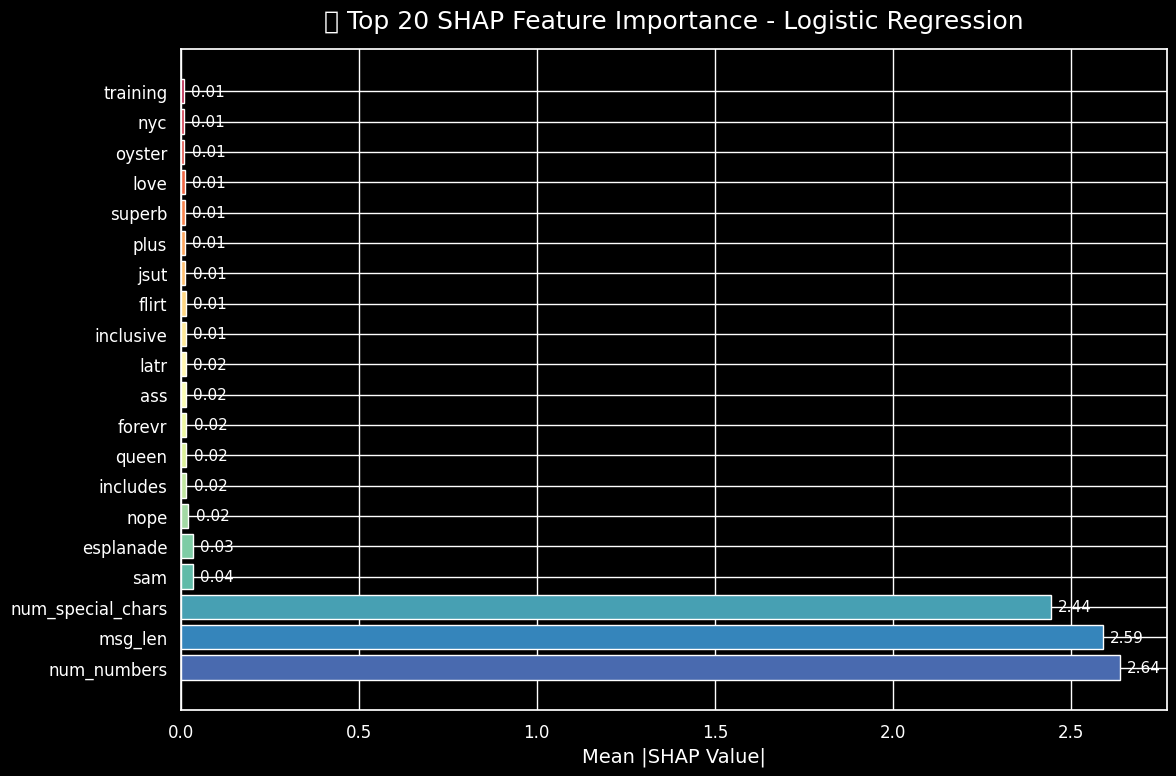

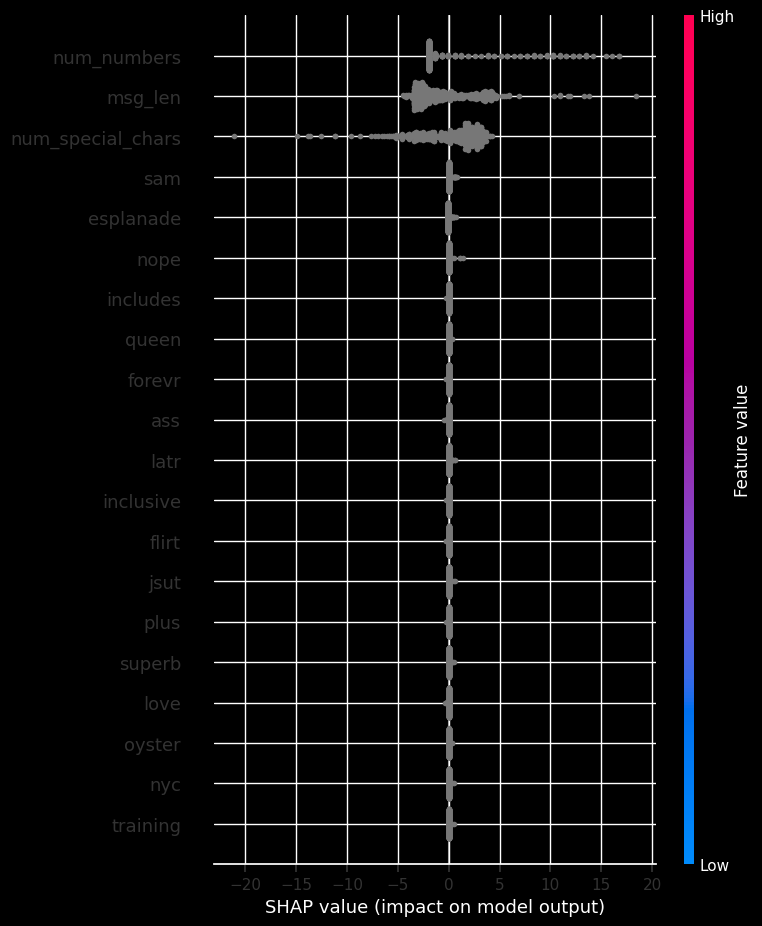

In [38]:
# ============================
# Fixed SHAP Horizontal Bar Plot
# ============================

import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Compute SHAP values
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test[:500])  # limit to 500 samples for speed

# Aggregate mean absolute SHAP values per feature
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=True)

# Limit top N features to avoid clutter
top_n = 20
shap_df_top = shap_df.tail(top_n)

# Modern Horizontal Bar Plot
plt.figure(figsize=(12,8))
colors = sns.color_palette("Spectral", n_colors=top_n)  # distinct colors for each bar
bars = plt.barh(shap_df_top['feature'], shap_df_top['mean_abs_shap'], color=colors)
plt.xlabel("Mean |SHAP Value|", fontsize=14)
plt.title(f"🧩 Top {top_n} SHAP Feature Importance - {best_model_name}", fontsize=18, pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # largest value on top

# Optional: add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

# Optional: interactive SHAP summary dot plot
shap.summary_plot(shap_values, X_test[:500], feature_names=feature_names, plot_type="dot", show=True)
